In [16]:
# Notebook for isolating triggers and releases

# Load data
import numpy as np
import matplotlib.pyplot as plt

# Width of triggers 
width = 32 
fileName = "second_collection"
data = np.load((fileName+".npz"))

In [17]:
# Find signal triggers
def findTrigIdxs(signal):
    """
    Finds the indexes of the signal where the trigger happens
    """
    zerosIdx = np.argwhere(signal<=0.05)        # Define zero as anything below harcoded value 
    jumpIdx = np.argwhere(np.diff(zerosIdx[:, 0])>1)   # Non-consecutive zeros
    trigIdx =  zerosIdx[jumpIdx]
    releaseIdx = zerosIdx[jumpIdx+1]
    return trigIdx.flatten(), releaseIdx.flatten()


def separateIntoTriggers(signal, trigIdx, releaseIdx, width=width):
    triggers = []
    releases = []

    short_trigs= []
    false_trigs= []

    for i, j in zip(trigIdx, releaseIdx):
        upSig = signal[i:i+width]
        downSig = signal[j-width:j]

        if np.mean(upSig<=0.5)>=0.8:          # Hardcoded threshold to select only clean signals
            false_trigs.append(upSig)
        else:
            if np.any(upSig[-10:]<=1.5):    # Check that this length doe not include release
                short_trigs.append(upSig)
            else:
                # TODO: Need to confirm that approach below is matching up triggers to releases correctly
                triggers.append(upSig) 
                releases.append(downSig)

    print("\nNumber of signals excluded because false noise: ", len(false_trigs))
    print("Number of signals excluded becasue too short: ", len(short_trigs))

    return np.array(triggers), np.array(releases), (np.array(false_trigs), np.array(short_trigs))


def plotTriggers(triggers, nx_plots=10, ny_plots=2):
    plt.figure(figsize=(nx_plots*2, ny_plots*2))
    for i in range(nx_plots * ny_plots):
        plt.subplot(ny_plots, nx_plots, i+1)
        trig = triggers[i]
        plt.plot(range(len(trig)), trig, "b.")
        plt.xticks([])


def plotSignal(signal, upTo):
    plt.figure(figsize=(30, 5))
    signal = signal[:upTo]
    plt.plot(range(len(signal)), signal, "b.")
    plt.show()

In [18]:
# Look at a few triggers of one of the users
key = "J"
signal = data[key]   # Only a few presses 
print("Signal shape:", signal.shape)
# plotSignal(signal, upTo=10000)
trigIdx, relIdx = findTrigIdxs(signal)
triggers, releases, faulty = separateIntoTriggers(signal, trigIdx, relIdx)

Signal shape: (899996,)

Number of signals excluded because false noise:  661
Number of signals excluded becasue too short:  18


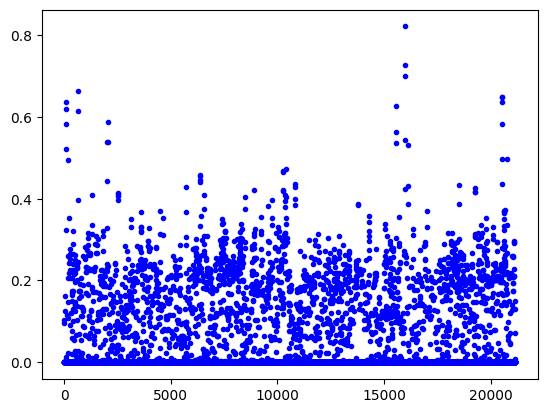

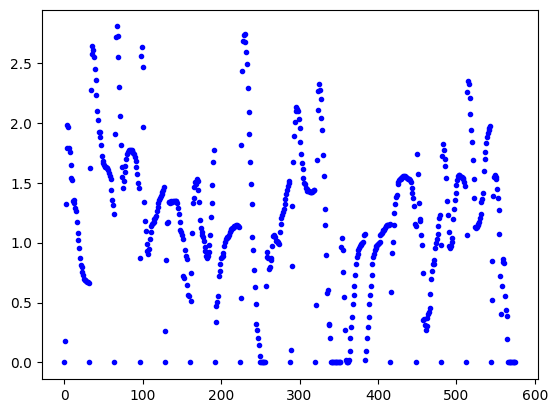

In [19]:
# Plot noisy triggers to make sure they are faulty signals 
# Best to see on a matplotlib plot rather than a jupyter notebook
false_trigs, short_trigs = faulty
for f_trig in (false_trigs, short_trigs):
    if len(f_trig)==0: continue
    false_sig = np.concatenate(f_trig)
    plt.figure()
    plt.plot(np.arange(len(false_sig)), false_sig, "b.")
    plt.show()

triggers shape: (2459, 64)
releases shape:  (2459, 64)


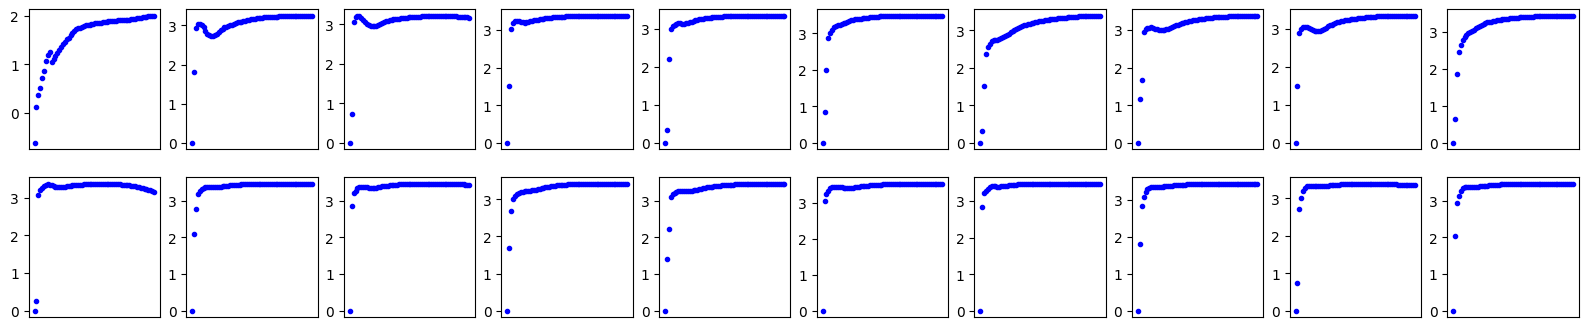

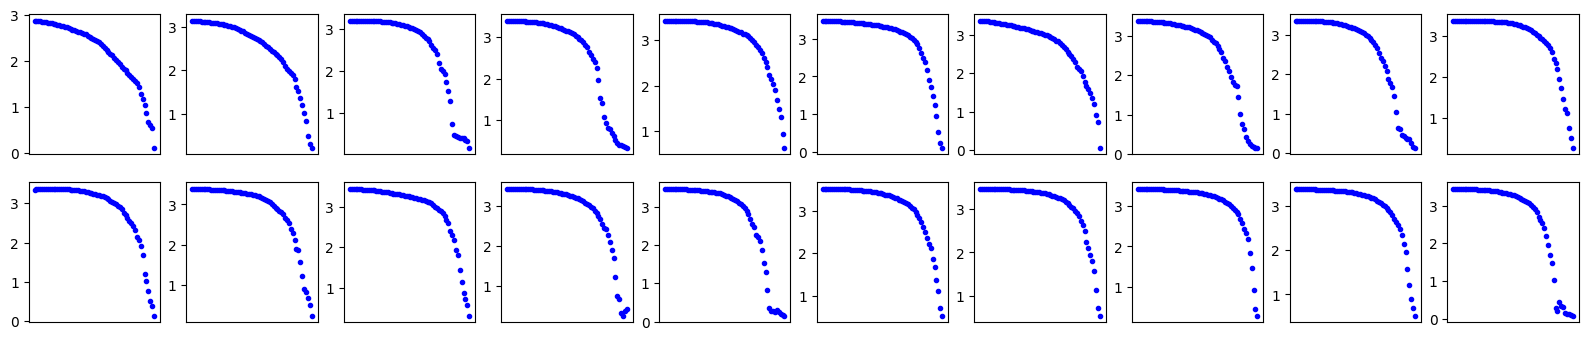

In [5]:
print("triggers shape:", triggers.shape)
print("releases shape: ", releases.shape)
plotTriggers(triggers) 
plotTriggers(releases)


Number of signals excluded because false noise:  1220
Number of signals excluded becasue too short:  1

Number of signals excluded because false noise:  145
Number of signals excluded becasue too short:  269

Number of signals excluded because false noise:  661
Number of signals excluded becasue too short:  18


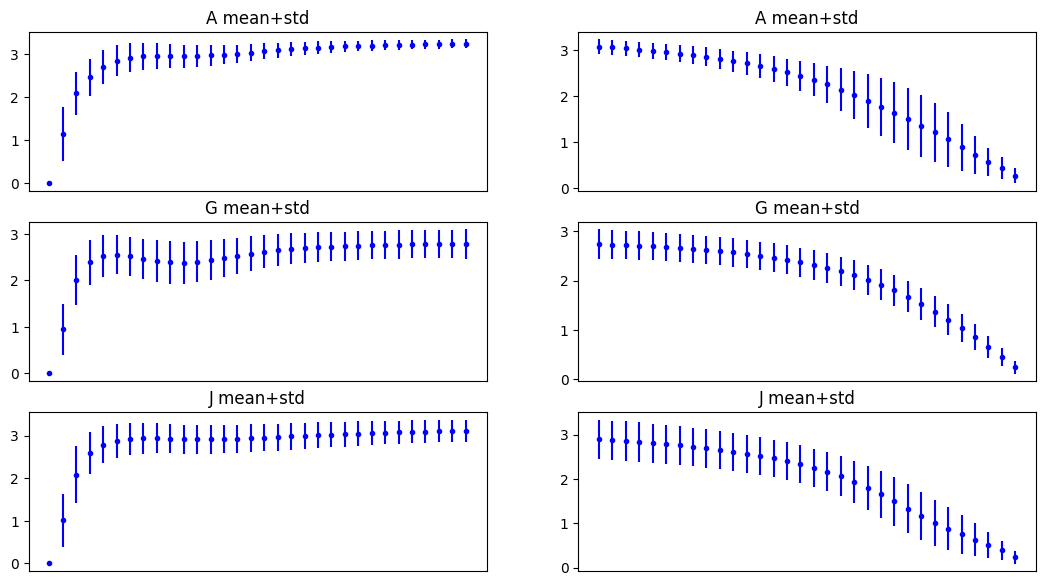

In [20]:
# Compare the mean and std of the signals for all the users involved
plt.figure(figsize=(13, 7))
n_users = len(data)
for i, key in enumerate(data):
    trigIdx, relIdx = findTrigIdxs(data[key])
    triggers, releases, _ = separateIntoTriggers(data[key], trigIdx, relIdx)
    for j, sig in enumerate([triggers, releases]):
        plt.subplot(n_users, 2, 2*i+j+1)
        sigAvg = np.mean(sig, axis=0)
        sigStd = np.std(sig, axis=0)
        plt.title(key+" mean+std")
        plt.errorbar(np.arange(len(sigAvg)), sigAvg, sigStd, fmt="b.")
        plt.xticks([])

In [21]:
# Loop to build and save data 
# Only run if want to update saved file 
filteredData = {}
for key in data:
    print(f"\nUser {key}:")
    signal = data[key].flatten()
    trigIdx, relIdx = findTrigIdxs(signal)
    triggers, releases, _ = separateIntoTriggers(signal, trigIdx, relIdx)
    filteredData[key+"_triggers"] = triggers
    filteredData[key+"_releases"] = releases 
    print(f"saving {key}_triggers: ", triggers.shape)
    print(f"saving {key}_releases: ", releases.shape)

output = fileName + "_triggs_rels" + f"_{triggers.shape[1]}.npz"
np.savez(output, **filteredData)


User A:

Number of signals excluded because false noise:  1220
Number of signals excluded becasue too short:  1
saving A_triggers:  (2258, 32)
saving A_releases:  (2258, 32)

User G:

Number of signals excluded because false noise:  145
Number of signals excluded becasue too short:  269
saving G_triggers:  (2691, 32)
saving G_releases:  (2691, 32)

User J:

Number of signals excluded because false noise:  661
Number of signals excluded becasue too short:  18
saving J_triggers:  (2548, 32)
saving J_releases:  (2548, 32)
